<a href="https://colab.research.google.com/github/shaghayegh5ghasemi/supervised_fuzzy_clustering/blob/main/Supervised_Fuzzy_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as f
import numpy as np


# Initial Images

In [ ]:
# load data
trainset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(dataset=trainset, batch_size=1, shuffle=True)
testset = datasets.CIFAR10(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
testloader = DataLoader(dataset=testset, batch_size=1, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def get_part_of_dataset(trainloader):
  dataset = []
  labels = []
  c = [0]*10
  for i, (input, label) in enumerate(trainloader):
    if all(x == 16 for x in c):
      break
    if c[label[0]] == 16:
      continue
    else:
      c[label[0]] += 1
      dataset.append(input[0])
      labels.append(label[0])
  return dataset, labels

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# dataset keeps our windows, class_label_matrix keeps the label of windows
dataset, labels = get_part_of_dataset(trainloader)

# Create windows

In [ ]:
# plot the image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def make_window(channel, dataset_channel, class_label_matrix, img, label, size, step, number_of_dimensions, number_of_classes):
  windows = img.unfold(1, size, step).unfold(2, size, step) # unflod(dimension, size, step)
  for i in range(len(windows[0])):
    for j in range(len(windows[0])):
      dataset_channel.append(windows[channel, i, j].reshape(number_of_dimensions))
      
      temp = [0]*number_of_classes
      temp[label] = 1
      class_label_matrix.append(temp)

In [ ]:
def make_dataset(channel, dataset_channel, class_label_matrix, dataset, labels, size, step, number_of_dimensions, number_of_classes):
  for i in range(len(dataset)):
    make_window(channel, dataset_channel, class_label_matrix, dataset[i], labels[i], size, step, number_of_dimensions, number_of_classes)

# Main functions

In [ ]:
def initialize_centroids(dataset, centroids, inverted_covariances, covariances, gamma, sigma, threshold, number_of_dimensions):
  number_of_centroids = 0
  for data in dataset:
    if number_of_centroids == 0:
      number_of_centroids += 1
      centroids.append(data)
      covariances.append(sigma*torch.eye(number_of_dimensions, dtype=torch.float64))
      inverted_covariances.append(torch.eye(number_of_dimensions, dtype=torch.float64)/sigma)
    else:
      temp = torch.stack(centroids)
      xc = data-temp
      distances = []
      for i in range(len(centroids)):
        distances.append(xc[i].reshape((1, number_of_dimensions))@inverted_covariances[i]@torch.transpose(xc[i].reshape((1, number_of_dimensions)), 0, 1))
      distances = -1*gamma*torch.tensor(distances)
      RM = torch.exp(distances)
      if max(RM) < threshold:
        number_of_centroids += 1
        centroids.append(data)
        covariances.append(sigma*torch.eye(number_of_dimensions, dtype=torch.float64))
        inverted_covariances.append(torch.eye(number_of_dimensions, dtype=torch.float64)/sigma)

In [ ]:
from torch.nn.functional import normalize
def calculate_membership_matrix(dataset ,centroids, inverted_covariances, gamma, number_of_dimensions):
  list_RM = []
  for i in range(len(centroids)):
    xc = dataset-centroids[i]
    temp = ((xc@inverted_covariances[i])*xc)@torch.ones((number_of_dimensions, 1), dtype=torch.float64)
    mem = torch.exp(-1*gamma*temp)
    list_RM.append(mem)
  #normalize the matirx
  RM = torch.cat(list_RM, dim=1)
  miu_ik = normalize(RM, p=1.0, dim = 1)
  return torch.nan_to_num(miu_ik)

In [ ]:
def update_centroids(dataset_channel, class_label_matrix, centroids, inverted_covariances, q, gamma, beta, number_of_dimensions):
  number_of_classes = len(class_label_matrix[0])
  updated_centroid = []
  miu_ik = calculate_membership_matrix(dataset_channel , centroids, inverted_covariances, gamma, number_of_dimensions)

  for i in range(len(centroids)):
    temp = class_label_matrix*miu_ik[:, [i]]
    cnt = torch.sum(temp, 0).reshape((1, number_of_classes)) 

    if torch.sum(cnt) == 0:
      q[i, :] = torch.zeros((1, number_of_classes))
    else:
      q[i, :] = cnt/torch.sum(cnt)

    Ui = torch.sum(q[i]*class_label_matrix, 1).reshape([len(dataset_channel), 1])*miu_ik[:, [i]] # Pik = torch.sum(q[i]*class_label_matrix, 1).reshape([len(dataset), 1])
    new_c = torch.nan_to_num((1-beta)*centroids[i] + beta*((torch.transpose(Ui, 0, 1)@dataset_channel)/torch.sum(Ui))) # in case that all the elements in Ui become zero
    updated_centroid.append(new_c)

  return updated_centroid

In [ ]:
def calculate_inverted_covariance(covariance):
  covariance = np.array(covariance)
  l, mygamma = np.linalg.eig(covariance) # calculate eigenvalues and eigenvectors
  mylambda = np.zeros((l.shape[0], l.shape[0])) # construct a diagnosal matrix with eigenvalues
  # normalize the matirx
  if l.dtype == "complex":
    l = abs(l)
  sum_of_rows = l.sum()
  if sum_of_rows != 0:
    l_norm = l/sum_of_rows
  else:
    l_norm = l
  for i in range(l.shape[0]):
    if l_norm[i] < 0.01:
      mylambda[i][i] = np.float64(0)
    else:
      mylambda[i][i] = np.float64(1/l[i])
  icm = (mygamma)@(mylambda)@(mygamma.T) # invert of the covariance matrix
  icm = np.float64(icm)
  return torch.tensor(icm)

In [ ]:
def update_covariances(dataset_channel, class_label_matrix, centroids, covariances, inverted_covariances, q, classes, gamma, beta, number_of_dimensions):
  number_of_classes = len(class_label_matrix[0])
  miu_ik = calculate_membership_matrix(dataset_channel ,centroids, inverted_covariances, gamma, number_of_dimensions)

  for i in range(len(centroids)):
    temp = class_label_matrix*miu_ik[:, [i]]
    cnt = torch.sum(temp, 0).reshape((1, number_of_classes))

    if torch.sum(cnt) == 0:
      q[i, :] = torch.zeros((1, number_of_classes))
    else:
      q[i, :] = cnt/torch.sum(cnt)
    
    Ui = torch.sum(q[i]*class_label_matrix, 1).reshape([len(dataset_channel), 1])*miu_ik[:, [i]]
    x_clusteri = dataset_channel - centroids[i]
    temp2 = torch.transpose(Ui*x_clusteri, 0, 1)@x_clusteri
    covariances[i] = (1-beta)*covariances[i] + beta*temp2/torch.sum(Ui)
    covariances[i] = torch.nan_to_num(covariances[i]) # in case that all the elements in Ui become zero

    inverted_covariances[i] = calculate_inverted_covariance(covariances[i])

In [ ]:
def calculate_entropy(q):
  ent = -1*torch.sum(torch.mean(q*torch.log(q + 0.1), 0), axis=0)
  return ent

# Body

In [ ]:
# initialize the centroids and the parameters
number_of_dimensions = 9
number_of_classes = len(classes)
size = 3 # 3x3 window size
step = 2 # one layer of overlap

gamma = 1
sigma = 0.5
threshold = 0.03
beta = 1

iteration = 400

In [ ]:
def suppervised_fuzzy_clustering(dataset, labels, iteration, number_of_dimensions, number_of_classes, size, step, gamma, sigma, threshold, beta):
  centroids_channel = []
  icm_channel = []
  entropy_channel = []
  for color_channel in range(3):
    print(f'color channel {color_channel} started.')
    dataset_channel = []
    class_label_matrix = []

    # centroid and cov of each cluster
    centroids = []
    covariances = []
    inverted_covariances = []

    make_dataset(color_channel, dataset_channel, class_label_matrix, dataset, labels, size, step, number_of_dimensions, number_of_classes)
    dataset_channel = torch.stack(dataset_channel)
    dataset_channel = dataset_channel.type(torch.DoubleTensor)
    class_label_matrix = torch.tensor(class_label_matrix, dtype=torch.float64)

    initialize_centroids(dataset_channel, centroids, inverted_covariances, covariances, gamma, sigma, threshold, number_of_dimensions)
    print(len(centroids))
    q = torch.zeros((len(centroids), number_of_classes), dtype=torch.float64) # matrix that contains the probibilities number of clusters x number of classes

    entropy_curve = []
    for i in range(iteration):
      centroids = update_centroids(dataset_channel, class_label_matrix, centroids, inverted_covariances, q, gamma, beta, number_of_dimensions)
      update_covariances(dataset_channel, class_label_matrix, centroids, covariances, inverted_covariances, q, classes, gamma, beta, number_of_dimensions)
      entropy = calculate_entropy(q)
      entropy_curve.append(entropy)
      print(f'{i}th Entropy = {entropy}')
      
    centroids_channel.append(centroids)
    icm_channel.append(inverted_covariances)
    entropy_channel.append(entropy_curve)

    print(f'color channel {color_channel} finished.')

  return centroids_channel, icm_channel, entropy_channel

In [ ]:
c, i, e = suppervised_fuzzy_clustering(dataset, labels, iteration, number_of_dimensions, number_of_classes, size, step, gamma, sigma, threshold, beta)

In [ ]:
centroids_channel, icm_channel, entropy_channel = suppervised_fuzzy_clustering(dataset, labels, iteration, number_of_dimensions, number_of_classes, size, step, gamma, sigma, threshold, beta)

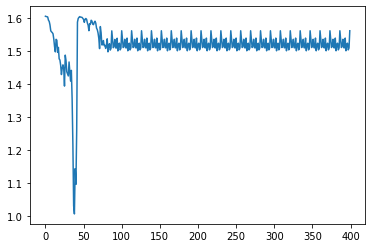

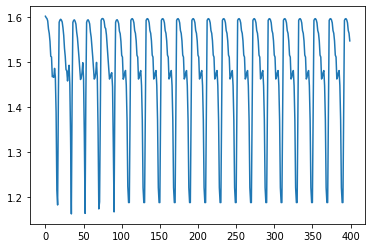

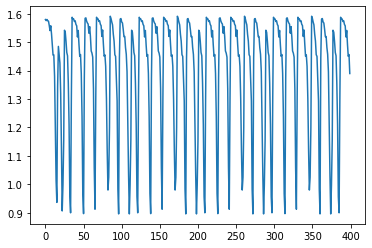

In [ ]:
import matplotlib.pyplot as plt
plt.plot(e[0])
plt.show()

plt.plot(e[1])
plt.show()

plt.plot(e[2])
plt.show()

# Test the output

In [ ]:
def calculate_mahanalobis_distance(icm, m, x, number_of_dimensions):
  # D^2 = (x-m)^T * C^-1 * (x-m), mahanalobis distance formula
  s = x.reshape((number_of_dimensions, 1))-m.reshape((number_of_dimensions, 1))
  return torch.transpose(s, 0, 1)@icm@s

In [ ]:
def calculate_membership(icm, vi, x, gamma, number_of_dimensions):
  distance = calculate_mahanalobis_distance(icm, vi, x, number_of_dimensions)
  # if torch.exp(-1*gamma*distance) < 0.0001:
  #   return torch.array(0.0001)
  # else:
  return torch.exp(-1*gamma*distance)

In [ ]:
filter_img = dataset[0]
filter_label = labels[0]

In [ ]:
windows = [[], [], []]

for color in range(3):
  for i in range(1, len(filter_img[0])-1):
    for j in range(1, len(filter_img[0])-1):
      temp = torch.zeros((3, 3))
      temp[0, 0] = filter_img[color, i-1, j-1]
      temp[0, 1] = filter_img[color, i-1, j]
      temp[0, 2] = filter_img[color, i-1, j+1]
      temp[1, 0] = filter_img[color, i, j-1]
      temp[1, 1] = filter_img[color, i, j]
      temp[1, 2] = filter_img[color, i, j+1]
      temp[2, 0] = filter_img[color, i+1, j-1]
      temp[2, 1] = filter_img[color, i+1, j]
      temp[2, 2] = filter_img[color, i+1, j+1]
      windows[color].append(temp)

In [ ]:
windows_r = windows[0]
windows_r = torch.stack(windows_r)
windows_r = windows_r.reshape(30, 30, 3, 3)

windows_g = windows[1]
windows_g = torch.stack(windows_g)
windows_g = windows_g.reshape(30, 30, 3, 3)

windows_b = windows[2]
windows_b = torch.stack(windows_b)
windows_b = windows_b.reshape(30, 30, 3, 3)

In [ ]:
result_r = torch.zeros((30, 30))
result_g = torch.zeros((30, 30))
result_b = torch.zeros((30, 30))

for i in range(30):
  for j in range(30):
    result_r[i][j] = calculate_membership(icm_channel[0][0], centroids_channel[0][0], windows_r[i, j], gamma, 9)
    result_g[i][j] = calculate_membership(icm_channel[1][0], centroids_channel[1][0], windows_g[i, j], gamma, 9)
    result_b[i][j] = calculate_membership(icm_channel[2][0], centroids_channel[2][0], windows_b[i, j], gamma, 9)

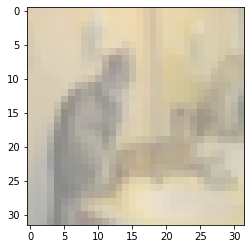

    c a t


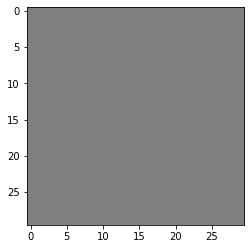

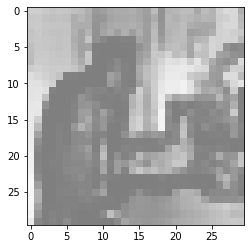

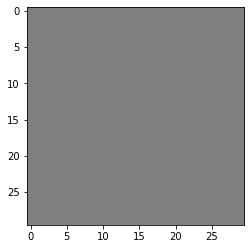

In [ ]:
imshow(torchvision.utils.make_grid(filter_img))
print(' '.join('%5s' % classes[filter_label]))

imshow(torchvision.utils.make_grid(result_r))
imshow(torchvision.utils.make_grid(result_g))
imshow(torchvision.utils.make_grid(result_b))

In [ ]:
result = [result_r, result_g, result_b]
result = torch.stack(result)

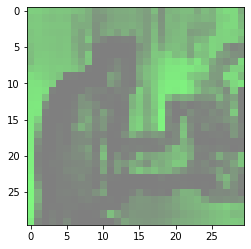

In [ ]:
imshow(torchvision.utils.make_grid(result))

In [ ]:
result_r_2 = torch.zeros((30, 30))
result_g_2 = torch.zeros((30, 30))
result_b_2 = torch.zeros((30, 30))

for i in range(30):
  for j in range(30):
    result_r_2[i][j] = calculate_membership(icm_channel[0][1], centroids_channel[0][1], windows_r[i, j], gamma, 9)
    result_g_2[i][j] = calculate_membership(icm_channel[1][1], centroids_channel[1][1], windows_g[i, j], gamma, 9)
    result_b_2[i][j] = calculate_membership(icm_channel[2][1], centroids_channel[2][1], windows_b[i, j], gamma, 9)

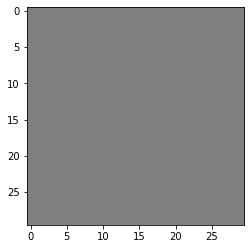

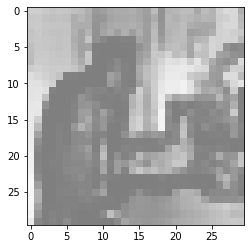

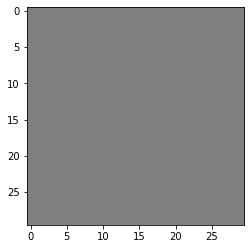

In [ ]:
imshow(torchvision.utils.make_grid(result_r))
imshow(torchvision.utils.make_grid(result_g))
imshow(torchvision.utils.make_grid(result_b))

In [ ]:
result2 = [result_r_2, result_g_2, result_b_2]
result2 = torch.stack(result2)

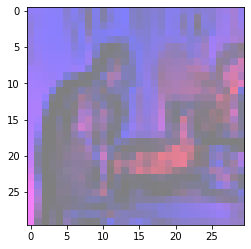

In [ ]:
imshow(torchvision.utils.make_grid(result2))

#Softmax

In [ ]:
softmax = nn.Softmax(dim=1)
cr = torch.cat(centroids_channel[0])
cg = torch.cat(centroids_channel[1])
cb = torch.cat(centroids_channel[2])
cr = softmax(cr)
cg = softmax(cg)
cb = softmax(cb)

In [ ]:
rr = torch.zeros((30, 30))
rg = torch.zeros((30, 30))
rb = torch.zeros((30, 30))

for i in range(30):
  for j in range(30):
    rr[i][j] = calculate_membership(icm_channel[0][0], cr[0], windows_r[i, j], gamma, 9)
    rg[i][j] = calculate_membership(icm_channel[1][0], cg[0], windows_g[i, j], gamma, 9)
    rb[i][j] = calculate_membership(icm_channel[2][0], cb[0], windows_b[i, j], gamma, 9)

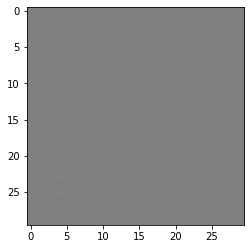

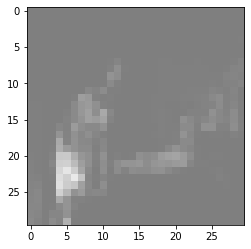

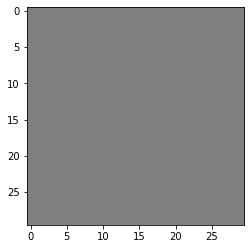

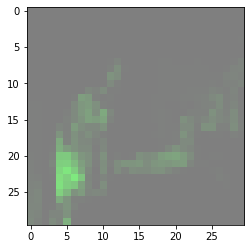

In [ ]:
imshow(torchvision.utils.make_grid(rr))
imshow(torchvision.utils.make_grid(rg))
imshow(torchvision.utils.make_grid(rb))

r = [rr, rg, rb]
r = torch.stack(r)

imshow(torchvision.utils.make_grid(r))

In [ ]:
rr2 = torch.zeros((30, 30))
rg2 = torch.zeros((30, 30))
rb2 = torch.zeros((30, 30))

for i in range(30):
  for j in range(30):
    rr2[i][j] = calculate_membership(icm_channel[0][1], cr[1], windows_r[i, j], gamma, 9)
    rg2[i][j] = calculate_membership(icm_channel[1][1], cg[1], windows_g[i, j], gamma, 9)
    rb2[i][j] = calculate_membership(icm_channel[2][1], cb[1], windows_b[i, j], gamma, 9)

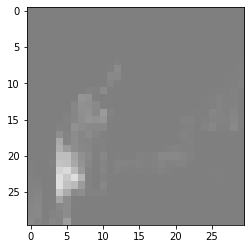

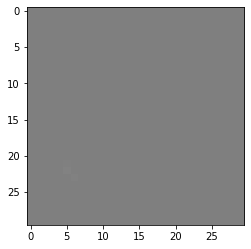

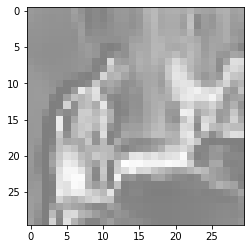

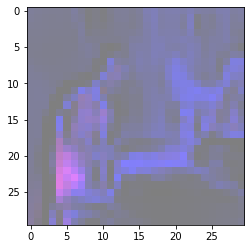

In [ ]:
imshow(torchvision.utils.make_grid(rr2))
imshow(torchvision.utils.make_grid(rg2))
imshow(torchvision.utils.make_grid(rb2))

r2 = [rr2, rg2, rb2]
r2 = torch.stack(r2)

imshow(torchvision.utils.make_grid(r2))

# Diversity of classes in clusters

In [ ]:
dataset_channel = []
class_label_matrix = []
make_dataset(0, dataset_channel, class_label_matrix, dataset, labels, size, step, number_of_dimensions, number_of_classes)
dataset_channel = torch.stack(dataset_channel)
dataset_channel = dataset_channel.type(torch.DoubleTensor)
class_label_matrix = torch.tensor(class_label_matrix, dtype=torch.float64)

In [ ]:
windows_max_membership = []
for w in dataset_channel:
  memberships = []
  for i in range(len(centroids_channel[0])):
    memberships.append(calculate_membership(icm_channel[2][i], cr[i], w, gamma, number_of_dimensions))
  test = torch.tensor(memberships)
  windows_max_membership.append(torch.argmax(test))

In [ ]:
check = torch.zeros((len(centroids_channel[0]), number_of_classes))
for i in range(len(windows_max_membership)):
  row = windows_max_membership[i]
  col = torch.nonzero(class_label_matrix[i])
  check[row, col] += 1

In [ ]:
print(check)

tensor([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.]])


# old cells

In [ ]:
label = torch.tensor(12)
for i, (inputs, labels) in enumerate(testloader):
  if label != torch.tensor(12):
    break
  if labels[0] in [torch.tensor(0), torch.tensor(1), torch.tensor(2)]:
    image = inputs[0]
    label = labels[0]
print(' '.join('%5s' % classes[label]))
imshow(torchvision.utils.make_grid(image))

windows = image.unfold(1, 3, 2).unfold(2, 3, 2) # unflod(dimension, size, step)
test = []
for i in range(15):
  for j in range(15): 
    test.append(windows[:, i, j].reshape(27))

windows_max_membership = []
for w in test:
  memberships = []
  for i in range(len(centroids)):
    memberships.append(calculate_membership(inverted_covariances[i], centroids[i], w, gamma))
  test = torch.tensor(memberships)
  windows_max_membership.append(torch.argmax(test))


for i in range(len(test)):
  print(f'window number {i+1} belongs to cluster {windows_max_membership[i] + 1}')
  


In [ ]:
def calculate_mahanalobis_distance(icm, m, x, number_of_dimensions):
  # D^2 = (x-m)^T * C^-1 * (x-m), mahanalobis distance formula
  s = x.reshape((number_of_dimensions, 1))-m.reshape((number_of_dimensions, 1))
  return torch.transpose(s, 0, 1)@icm@s

In [ ]:
from torch.nn.functional import normalize
def calculate_membership_matrix(dataset ,centroids, inverted_covariances, gamma, number_of_dimensions):
  RM = torch.zeros((len(dataset), len(centroids)), dtype=torch.float62) # matrix that contains the memberships number of samples x number of clusters
  for i in range(len(centroids)):
    xc = dataset-centroids[i]
    temp = ((xc@inverted_covariances[i])*xc)@torch.ones((number_of_dimensions, 1))
    mem = torch.exp(-1*gamma*temp)
    RM[:, i] = mem[:, 0]
  #normalize the matirx
  miu_ik = normalize(RM, p=1.0, dim = 1)
  return miu_ik


In [ ]:
a = nn.InstanceNorm2d()

In [ ]:
train_set = datasets.CIFAR10(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

train_loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)
data = next(iter(train_loader))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
mean = [data[0][:, 0].mean(), data[0][:, 1].mean(), data[0][:, 2].mean()]
std = [data[0][:, 0].std(), data[0][:, 1].std(), data[0][:, 2].std()]
train_set_normal = datasets.CIFAR10(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
          transforms.ToTensor()
        , transforms.Normalize(mean, std)
    ])
)

train_loader_normal = DataLoader(train_set_normal, batch_size=1, num_workers=1, shuffle=True)

Files already downloaded and verified


In [ ]:
def make_window(dataset, class_label_matrix, img, label, size, step, number_of_dimensions, number_of_classes):
  windows = img.unfold(1, size, step).unfold(2, size, step) # unflod(dimension, size, step)

  for i in range(len(windows[0])):
    for j in range(len(windows[0])):
      
      window_normal = []
      for k in range(len(windows)): # number of channels
        window_normal.append((windows[:, i, j, k] - windows[:, i, j, k].mean())/windows[:, i, j, k].std())
      
      window_normal = torch.stack(window_normal)
      dataset.append(window_normal.reshape(number_of_dimensions))
      temp = [0]*number_of_classes
      temp[label] = 1
      class_label_matrix.append(temp)